# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [44]:
# Imports

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from scipy.ndimage.measurements import label

%matplotlib inline


# Helper Functions

def show_images(left, right, left_title='Left', right_title='Right', left_cmap='gray', right_cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
    f.tight_layout()
    ax1.imshow(left, cmap=left_cmap)
    ax1.set_title(left_title, fontsize=18)
    ax2.imshow(right, cmap=right_cmap)
    ax2.set_title(right_title, fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def read_image(location):
    return cv2.cvtColor(cv2.imread(location), cv2.COLOR_BGR2RGB)

## Read all Images

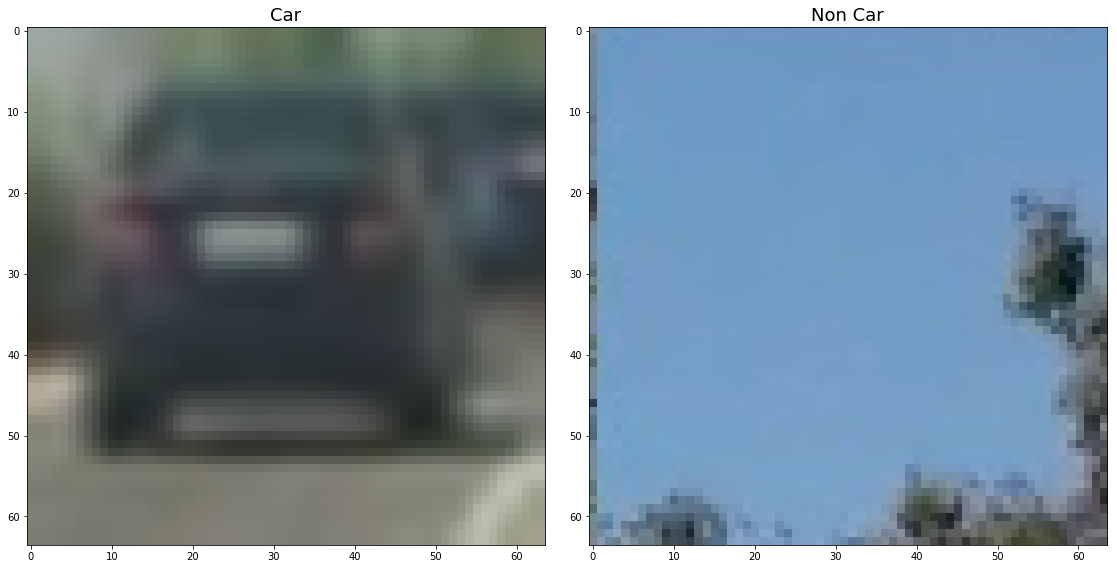

In [45]:
# Read car/noncar images
cars = glob.glob('training_data/vehicles/*/*.png')
noncars = glob.glob('training_data/non-vehicles/*/*.png')

car_image = read_image(cars[0])
noncar_image = read_image(noncars[0])

show_images(car_image, noncar_image, 'Car', 'Non Car')

## Define Feature Extraction Functions (HOG, Spatial, Histogram)

In [46]:
# Parameters

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
xy_window_size = (128, 128)
xy_overlap_size = (0.5, 0.5)

def normalise(image):
    return (image - image.mean()) / (image.max() - image.min())

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)
    
    
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Determine parameters (Experimentation)

### a. HOG Features

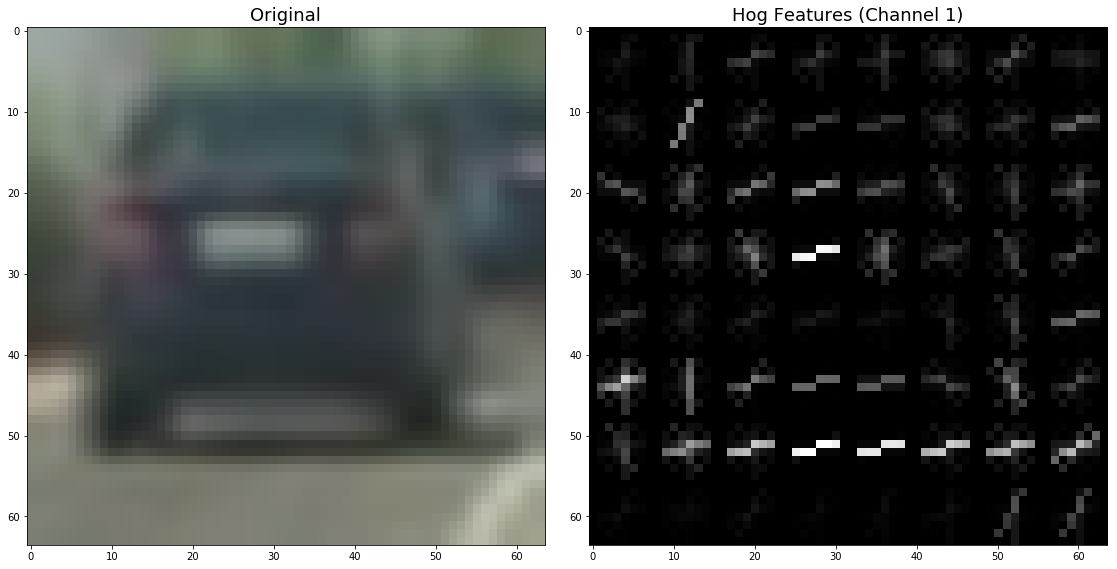

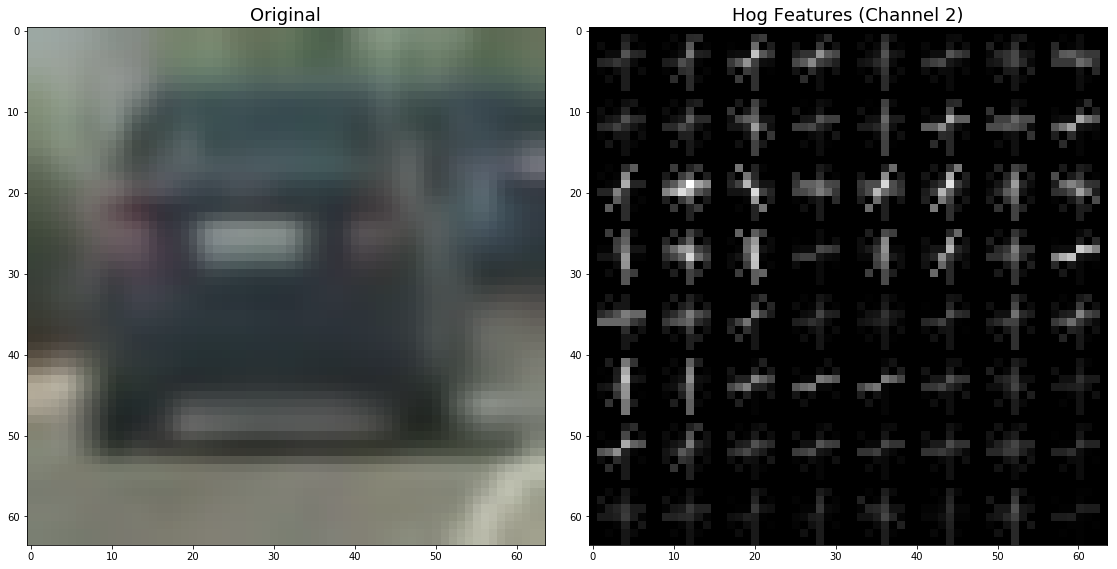

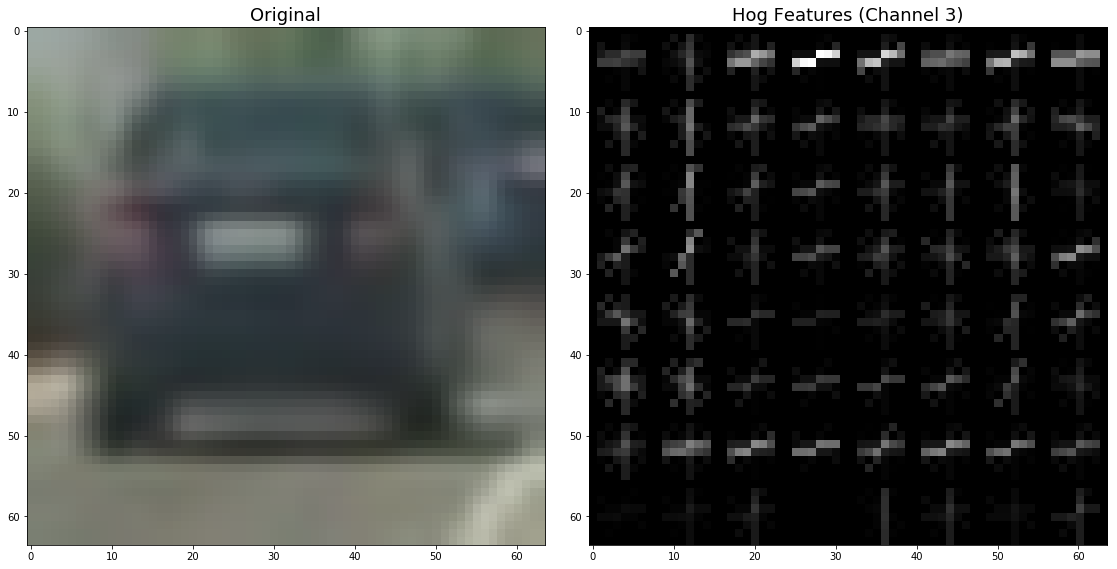

In [63]:
example_rgb_image = car_image
example_ycrcb_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)

hog_features_ch1, hog_image_ch1 = get_hog_features(example_ycrcb_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog_features_ch2, hog_image_ch2 = get_hog_features(example_ycrcb_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog_features_ch3, hog_image_ch3 = get_hog_features(example_ycrcb_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

show_images(car_image, hog_image_ch1, 'Original', 'Hog Features (Channel 1)')
show_images(car_image, hog_image_ch2, 'Original', 'Hog Features (Channel 2)')
show_images(car_image, hog_image_ch3, 'Original', 'Hog Features (Channel 3)')


### b. Spatially Binned Features

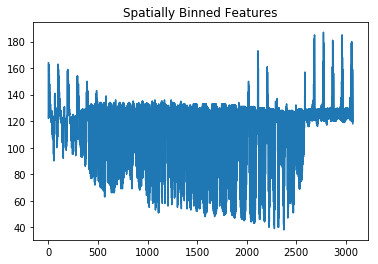

In [61]:
feature_vec = bin_spatial(example_ycrcb_image)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

### c. Histogram Features

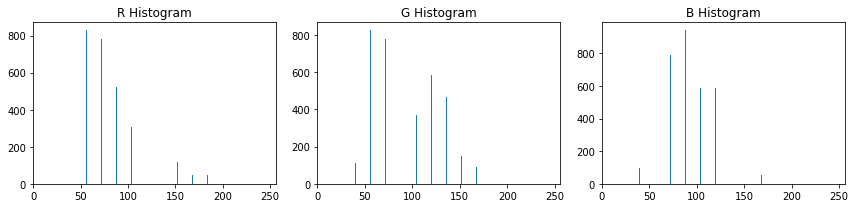

In [62]:
rh, gh, bh, bincen, feature_vec = color_hist(example_rgb_image, hist_bins)

if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

## Extract features for all car/non-car images

In [ ]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
noncar_features = extract_features(noncars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

## Create labeled training/validation set of extracted features

In [65]:
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Normalise input
X = normalise(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

print('Feature vector length:', len(X_train[0]))

100%|██████████| 8968/8968 [00:39<00:00, 224.26it/s]


Feature vector length: 6108


## Train a Linear SVM classifier

In [8]:
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)

Test Accuracy of SVC =  0.98958333


## Define Function for Sliding Window Implementation

In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Define Function for Finding Cars in an Image

In [67]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=False):
    bboxes = []
    windows = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            windows.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
            
            if test_prediction == 1:
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                
                if vis == True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                    plt.imshow(draw_img)
                
    return bboxes, windows

## Sliding Window Search Visualization

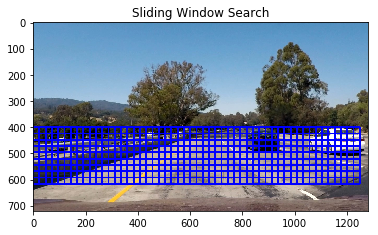

In [70]:
ystart = 400
ystop = 656
scale = 1.5
    
vis_boxes = False
test1 = mpimg.imread('test_images/test1.jpg')
test1_boxes, test1_windows = find_cars(test1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_boxes)

plt.imshow(draw_boxes(test1, test1_windows))
plt.title('Sliding Window Search')

## Testing Algorithm On Images 1-6

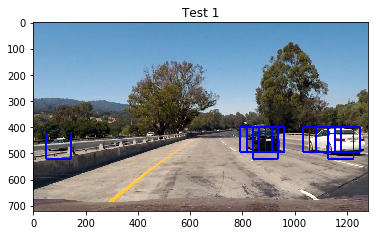

In [73]:
plt.imshow(draw_boxes(test1, test1_boxes))
plt.title('Test 1')

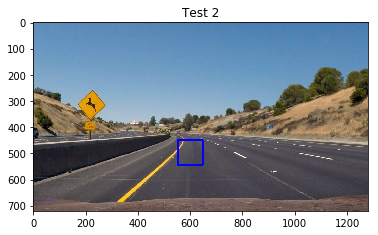

In [74]:
test2 = mpimg.imread('test_images/test2.jpg')
test2_boxes, test2_windows = find_cars(test2, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_boxes)
plt.imshow(draw_boxes(test2, test2_boxes))
plt.title('Test 2')

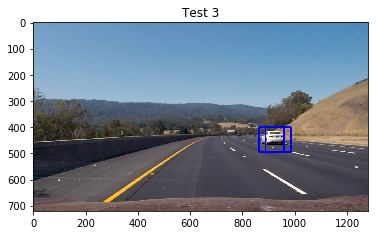

In [75]:
test3 = mpimg.imread('test_images/test3.jpg')
test3_boxes, test3_windows = find_cars(test3, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_boxes)
plt.imshow(draw_boxes(test3, test3_boxes))
plt.title('Test 3')

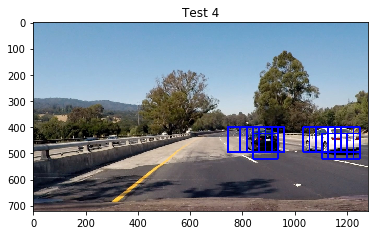

In [76]:
test4 = mpimg.imread('test_images/test4.jpg')
test4_boxes, test4_windows = find_cars(test4, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_boxes)
plt.imshow(draw_boxes(test4, test4_boxes))
plt.title('Test 4')

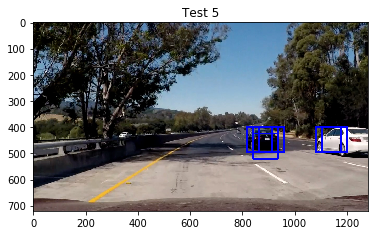

In [77]:
test5 = mpimg.imread('test_images/test5.jpg')
test5_boxes, test5_windows = find_cars(test5, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_boxes)
plt.imshow(draw_boxes(test5, test5_boxes))
plt.title('Test 5')

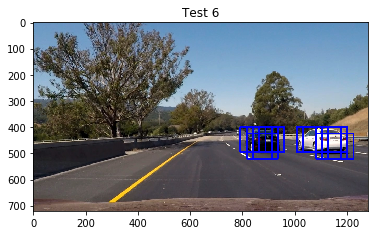

In [78]:
test6 = mpimg.imread('test_images/test6.jpg')
test6_boxes, test6_windows = find_cars(test6, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis_boxes)
plt.imshow(draw_boxes(test6, test6_boxes))
plt.title('Test 6')

## Heatmap Filter To Eliminate False Positives

In [80]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

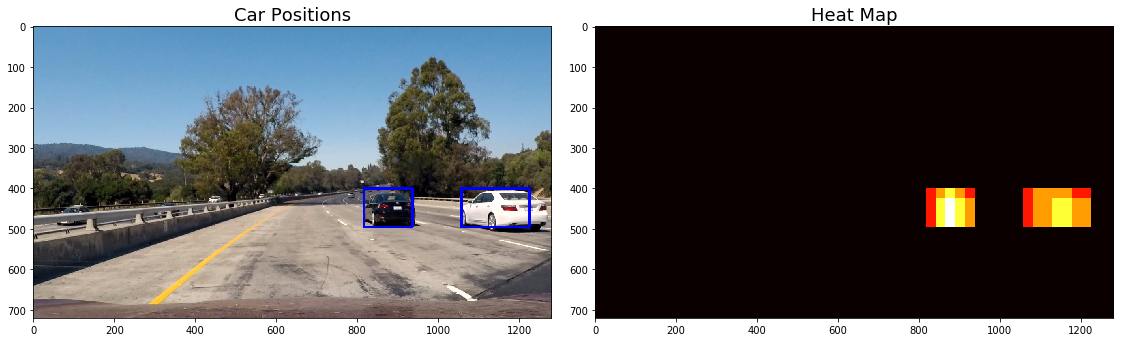

In [81]:
heat_p = np.zeros((720, 1280)) # Store prev heat image

def draw_boxes_with_heatmap(image, boxes):
    global heat_p
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
       
    heat = add_heat(heat, boxes)
    heat_l = heat_p + heat
    heat_p = heat
    heat_l = apply_threshold(heat_l,1) # Apply threshold to help remove false positives
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_l, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img, heatmap

draw_img, heatmap = draw_boxes_with_heatmap(test1, test1_boxes)
show_images(draw_img, heatmap, 'Car Positions', 'Heat Map', left_cmap='gray', right_cmap='hot')


## Video Pipeline

In [55]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    boxes, windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    return draw_boxes_with_heatmap(image, boxes)[0]

output_file = 'project_video_output.mp4'
original_file = VideoFileClip("project_video.mp4").subclip(10,20)
clip = original_file.fl_image(process_image)
%time clip.write_videofile(output_file, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 250/251 [01:19<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 15s, sys: 4.25 s, total: 1min 20s
Wall time: 1min 19s


In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))